# Aprendizado Profundo

### Redes Recorrentes para processamento de dados textuais

- Carregamento dos pacotes necessários
- Carregamento dos dados (IMDB dataset)
- Desenvolvimento de um modelo RNN Vanilla
- Desenvolvimento de um modelo RNN Bidirectional LSTM

<!-- Observações: 
- ativar a GPU (Menu [Runtime], opção [Change runtime type])
- Sem GPU, a execução deste caderno pode levar mais de 40 minutos. -->


# Pacotes

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import SimpleRNN, Dense, Activation, Embedding, LSTM, Bidirectional
from keras.utils import pad_sequences
from keras.datasets import imdb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Carregamento dos dados (IMDB)

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data

In [4]:
(X_train,Y_train), (X_test, Y_test) = imdb.load_data(path = "imdb.npz",
                                    num_words = None,
                                    skip_top = 0,
                                    maxlen = None,
                                    seed = 113,
                                    start_char = 1,
                                    oov_char = 2,
                                    index_from = 3)

17464789/17464789 [==============================] - 0s 0us/step


In [5]:
print("X_train: ",X_train.shape)
print("Y_train: ",Y_train.shape)
print("X_test: ",X_test.shape)
print("Y_test: ",Y_test.shape)

print("Classes existentes: ", np.unique(Y_train))

X_train:  (25000,)
Y_train:  (25000,)
X_test:  (25000,)
Y_test:  (25000,)
Classes existentes:  [0 1]


In [6]:
unique,  cc = np.unique(Y_train, return_counts = True)
print("Distribuição dos classes (treino): ", dict(zip(unique,cc)))

Distribuição dos classes (treino):  {0: 12500, 1: 12500}


In [7]:
unique,  cc = np.unique(Y_test, return_counts = True)
print("Distribuição dos classes (teste): ", dict(zip(unique,cc)))

Distribuição dos classes (teste):  {0: 12500, 1: 12500}


## Exemplos de Reviews (Sentenças)

In [8]:
# obtenção do dicionário (id --> palavra)
dicionario = imdb.get_word_index()
num_words = len(dicionario)
print("Número total de palavras no dicionário: ", num_words)

1641221/1641221 [==============================] - 0s 0us/step
Número total de palavras no dicionário:  88584


In [9]:
# Algumas palavras (10 mais frequentes)
for (word, id) in dicionario.items():
  if id <= 10:
    print(id, word)


10 i
9 it
6 is
8 in
4 of
3 a
7 br
1 the
2 and
5 to


In [10]:
def Decode(idx = 1):
    reverse_index = dict([(id,word) for (word, id) in dicionario.items()])
    sentenca = " ".join([reverse_index.get(i - 3, "!") for i in X_train[idx]])
    return sentenca

In [11]:
# Exemplo de sentença (ids)
idx = 5
sentenca = Decode(idx)
print("Ids: ", np.array(X_train[idx])-3) # subtração do 3 - codificação inicial
print("Sentenca: ", sentenca)
print("Comprimento: ", len(X_train[idx]))
print("Classe: ", Y_train[idx])



Ids:  [   -2   775   125    71     9   627   160    12     1  1763  7979  1048
 43219    29    82   153    42    37   145   136   118   661   662     7
     7  1358   170     1   746 86585    13  3801     5     1   223    62
     9    40   124    21 15341     7     7]
Sentenca:  ! begins better than it ends funny that the russian submarine crew outperforms all other actors it's like those scenes where documentary shots br br spoiler part the message dechifered was contrary to the whole story it just does not mesh br br
Comprimento:  43
Classe:  0


# Pré-processamento 

Padding, redução do dicionário e dimensão de embedding

In [12]:
# reduzindo o número de palavras no dicionário
# para reduzir o número de parâmetros do modelo
num_words = 5000
(X_train,Y_train), (X_test, Y_test) = imdb.load_data(num_words = num_words)

maxlen = 100 
embedding = 16


In [13]:
# Tamanho maximo da sentença
X_train = pad_sequences(X_train, maxlen = maxlen)
X_test = pad_sequences(X_test, maxlen = maxlen)

print(X_train[5])
decoded_review = Decode(5)

# palavras fora do dicionário (ausentes | >num_words)
# são substituídos por oov_char (2)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]


# Modelo 01: RNN Vanilla

## Definição do Modelo

In [14]:
modelo01 = keras.Sequential()
modelo01.add(Embedding(num_words, embedding, input_length = len(X_train[0])))
modelo01.add(SimpleRNN(10, return_sequences = True))
modelo01.add(SimpleRNN(10, return_sequences = False))
modelo01.add(Dense(1, activation="sigmoid"))

# modelo01.add(SimpleRNN(16, input_shape = (num_words, maxlen), return_sequences = False, activation = "relu"))
modelo01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           80000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 10)           270       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 80,491
Trainable params: 80,491
Non-trainable params: 0
_________________________________________________________________


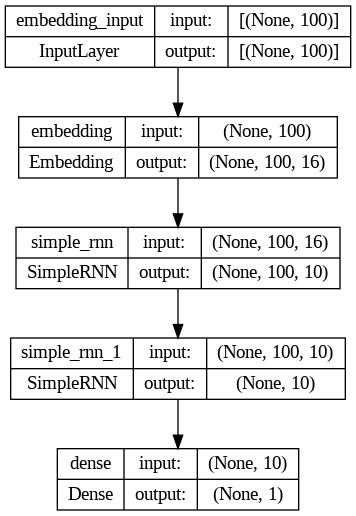

In [15]:
tf.keras.utils.plot_model(modelo01, show_shapes=True)

## Treinamento do Modelo01

In [16]:
modelo01.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics = ["accuracy"])
history = modelo01.fit(X_train, Y_train, validation_split=0.1, epochs = 10, batch_size = 128, verbose = 1)

Epoch 1/10
176/176 [==============================] - 55s 275ms/step - loss: 0.6089 - accuracy: 0.6619 - val_loss: 0.5154 - val_accuracy: 0.7604
Epoch 2/10
176/176 [==============================] - 42s 241ms/step - loss: 0.4451 - accuracy: 0.7980 - val_loss: 0.4984 - val_accuracy: 0.7724
Epoch 3/10
176/176 [==============================] - 37s 209ms/step - loss: 0.3439 - accuracy: 0.8563 - val_loss: 0.4338 - val_accuracy: 0.8080
Epoch 4/10
176/176 [==============================] - 36s 206ms/step - loss: 0.2898 - accuracy: 0.8819 - val_loss: 0.3783 - val_accuracy: 0.8320
Epoch 5/10
176/176 [==============================] - 37s 212ms/step - loss: 0.2496 - accuracy: 0.9012 - val_loss: 0.4046 - val_accuracy: 0.8376
Epoch 6/10
176/176 [==============================] - 35s 201ms/step - loss: 0.2191 - accuracy: 0.9137 - val_loss: 0.4148 - val_accuracy: 0.8376
Epoch 7/10
176/176 [==============================] - 34s 193ms/step - loss: 0.1877 - accuracy: 0.9299 - val_loss: 0.4118 - val_ac

## Avaliação

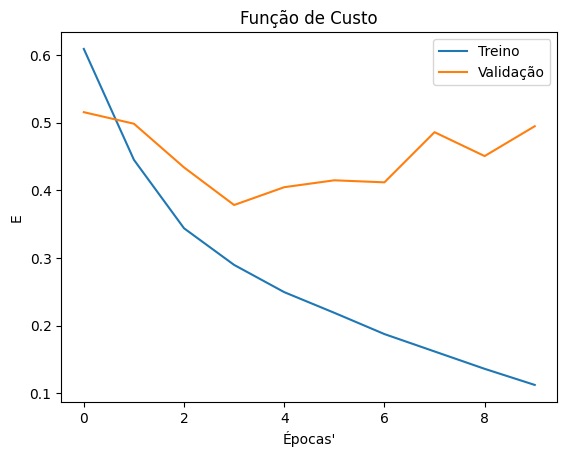

In [17]:
plt.figure()
plt.plot(history.history["loss"], label = "Treino")
plt.plot(history.history["val_loss"], label = "Validação")
plt.title("Função de Custo")
plt.ylabel("E")
plt.xlabel("Épocas'")
plt.legend()
plt.show()

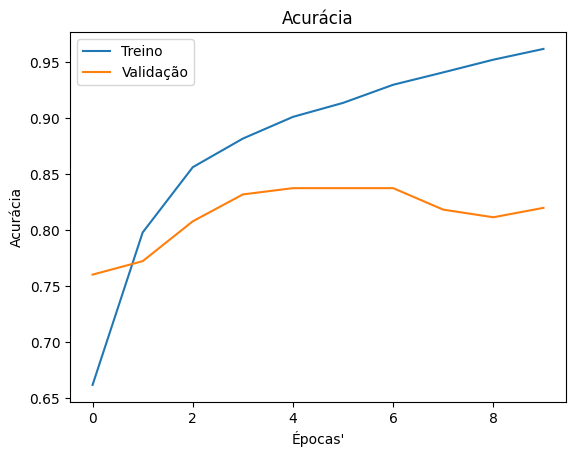

In [18]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Treino")
plt.plot(history.history["val_accuracy"], label = "Validação")
plt.title("Acurácia")
plt.ylabel("Acurácia")
plt.xlabel("Épocas'")
plt.legend()
plt.show()

## Acurácia no conjunto de teste

In [19]:
score = modelo01.evaluate(X_test, Y_test)
print("Acurácia final: %", score[1]*100)

782/782 [==============================] - 14s 18ms/step - loss: 0.4986 - accuracy: 0.8221
Acurácia final: % 82.21200108528137


<a id = "12"></a>
## Confusion Matrix

782/782 [==============================] - 14s 17ms/step


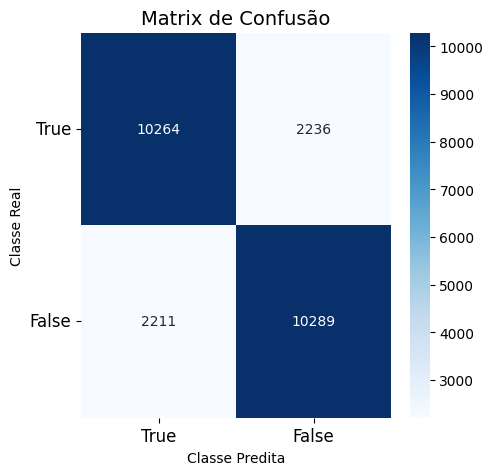

True Positive: 10264
True Negative: 10289
False Positive: 2236
False Negative: 2211


In [20]:
y_pred = modelo01.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(Y_test,y_pred)
df1 = pd.DataFrame(columns=["True","False"], index= ["True","False"], data= cm ) 

f,ax = plt.subplots(figsize=(5,5))
sns.heatmap(df1, annot=True,cmap="Blues", fmt= '.0f',ax=ax)
plt.xlabel("Classe Predita")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Classe Real")
plt.title("Matrix de Confusão", size = 14)
plt.show()

print ("True Positive:" , (cm[0,0]))
print ("True Negative:" , (cm[1,1]))
print ("False Positive:" , (cm[0,1]))
print ("False Negative:" , (cm[1,0]))

# Modelo 02: LSTM

## Definição do Modelo

In [21]:
modelo02 = keras.Sequential()
modelo02.add(Embedding(num_words, embedding, input_length = len(X_train[0])))
modelo02.add(LSTM(10, return_sequences=True))
modelo02.add(LSTM(10))
# modelo02.add(Bidirectional(LSTM(12, return_sequences=True)))
# modelo02.add(Bidirectional(LSTM(12)))
modelo02.add(Dense(1, activation="sigmoid"))

modelo02.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           80000     
                                                                 
 lstm (LSTM)                 (None, 100, 10)           1080      
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 81,931
Trainable params: 81,931
Non-trainable params: 0
_________________________________________________________________


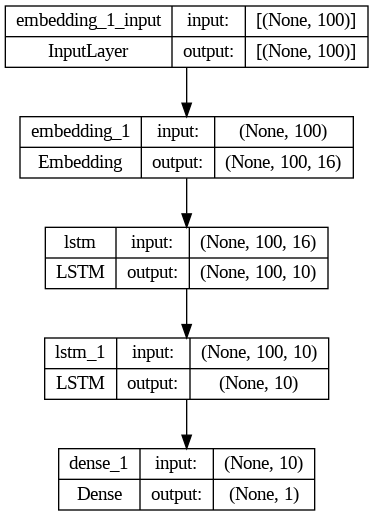

In [22]:
tf.keras.utils.plot_model(modelo02, show_shapes=True)

## Treinamento do Modelo01

In [23]:
modelo02.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics = ["accuracy"])
history = modelo02.fit(X_train, Y_train, validation_split=0.1, epochs = 10, batch_size = 128, verbose = 1)

Epoch 1/10
176/176 [==============================] - 18s 77ms/step - loss: 0.5775 - accuracy: 0.6845 - val_loss: 0.4519 - val_accuracy: 0.8020
Epoch 2/10
176/176 [==============================] - 6s 34ms/step - loss: 0.3847 - accuracy: 0.8382 - val_loss: 0.4100 - val_accuracy: 0.8228
Epoch 3/10
176/176 [==============================] - 4s 23ms/step - loss: 0.3195 - accuracy: 0.8700 - val_loss: 0.3678 - val_accuracy: 0.8416
Epoch 4/10
176/176 [==============================] - 3s 15ms/step - loss: 0.2895 - accuracy: 0.8860 - val_loss: 0.3640 - val_accuracy: 0.8428
Epoch 5/10
176/176 [==============================] - 3s 19ms/step - loss: 0.2680 - accuracy: 0.8940 - val_loss: 0.3678 - val_accuracy: 0.8388
Epoch 6/10
176/176 [==============================] - 3s 14ms/step - loss: 0.2518 - accuracy: 0.9019 - val_loss: 0.3882 - val_accuracy: 0.8404
Epoch 7/10
176/176 [==============================] - 2s 13ms/step - loss: 0.2425 - accuracy: 0.9059 - val_loss: 0.3560 - val_accuracy: 0.842

## Avaliação

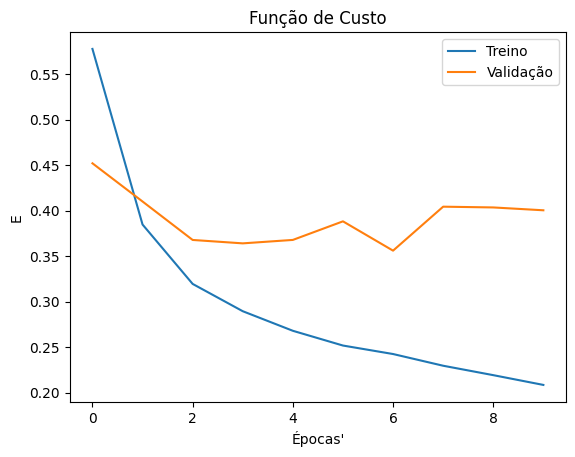

In [24]:
plt.figure()
plt.plot(history.history["loss"], label = "Treino")
plt.plot(history.history["val_loss"], label = "Validação")
plt.title("Função de Custo")
plt.ylabel("E")
plt.xlabel("Épocas'")
plt.legend()
plt.show()

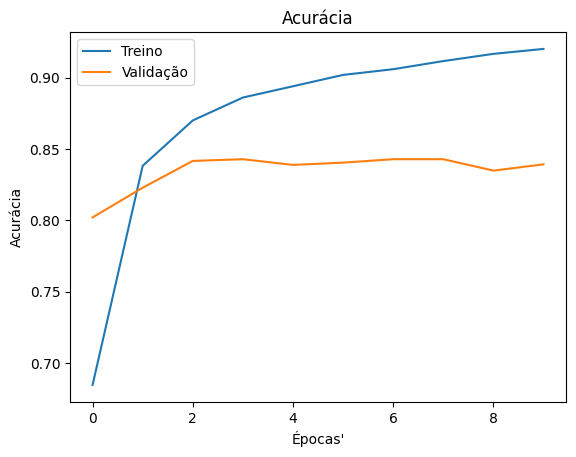

In [25]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Treino")
plt.plot(history.history["val_accuracy"], label = "Validação")
plt.title("Acurácia")
plt.ylabel("Acurácia")
plt.xlabel("Épocas'")
plt.legend()
plt.show()

## Acurácia no conjunto de teste

In [26]:
score = modelo02.evaluate(X_test, Y_test)
print("Acurácia final: %", score[1]*100)

782/782 [==============================] - 4s 5ms/step - loss: 0.4090 - accuracy: 0.8386
Acurácia final: % 83.85999798774719


<a id = "12"></a>
## Confusion Matrix

782/782 [==============================] - 4s 4ms/step


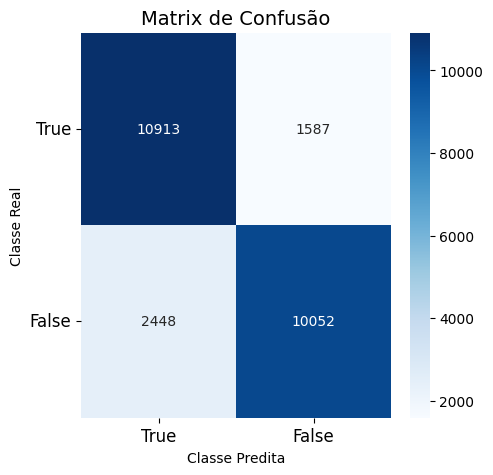

True Positive: 10913
True Negative: 10052
False Positive: 1587
False Negative: 2448


In [27]:
y_pred = modelo02.predict(X_test)
y_pred = (y_pred > 0.5)

cm = confusion_matrix(Y_test,y_pred)
df1 = pd.DataFrame(columns=["True","False"], index= ["True","False"], data= cm ) 

f,ax = plt.subplots(figsize=(5,5))
sns.heatmap(df1, annot=True,cmap="Blues", fmt= '.0f',ax=ax)
plt.xlabel("Classe Predita")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Classe Real")
plt.title("Matrix de Confusão", size = 14)
plt.show()

print ("True Positive:" , (cm[0,0]))
print ("True Negative:" , (cm[1,1]))
print ("False Positive:" , (cm[0,1]))
print ("False Negative:" , (cm[1,0]))

# Exercício de Apoio

### Possíveis modificações nos modelos acima:

- Topologia (número de neurônios / camadas)
- Tipo de neurônio (Vanilla, LSTM, GRU, Bidirecional)
- Regularização (L2, etc.)
- Tamanho do dicionário (num_words)
- Padding (maxlen)
- Embedding (embedding)

### Algumas sugestões:

1. Considerar dicionários com outros tamanhos (e.g., num_words={1000, 10000, etc.})
2. Realizar o padding com outros tamanhos (e.g., maxlen = {50, 150, etc.})
3. Utilizar outras dimensões de embedding (e.g., embedding = {8, 32, 64, 128, etc.}) 

Obs. Considere redes com parâmetros similares para efetuar as comparações, por exemplo, se adotar um embedding de 64, utilize-o para todos os modelos considerados.

Por fim, reporte os resultados no forum de discussão da semana




